In [1]:
from typing import Literal, Any, Sequence
import os
import datetime
import json

import tifffile as tiff
import numpy as np
import xarray as xr

from microsim import schema as ms
from microsim.schema.optical_config.lib import spectral_detector
from microsim.schema.optical_config import OpticalConfig

In [17]:
# --- Set simulation parameters
labels: str = ["ER", "F-actin", "Microtubules"]
"""The labels of the structures to simulate."""
fluorophores: str = ["mTurquoise", "EGFP", "EYFP"]
"""The fluorophores associated with the structures to simulate."""
num_bands: int = 32
"""The number of spectral bands to acquire (i.e., physically, the number of cameras)."""
light_wavelengths: Sequence[int] = [435, 488, 514]
"""List of lasers to use for excitation."""
light_powers: Sequence[float] = [3., 3., 1.]
"""List of powers associate to each light source (work as scaling factors)."""
out_range: tuple[int, int] = (460, 550)
"""The range of wavelengths of the acquired spectrum in nm."""
exposure_ms: float = 5
"""The exposure time for the detector cameras in ms."""

'The exposure time for the detector cameras in ms.'

In [18]:
def create_distribution(
    label: Literal["CCPs", "ER", "F-actin", "Microtubules"],
    fluorophore: str,
    root_dir: str,
    idx: int | None = None, 
) -> ms.FluorophoreDistribution:
    return ms.FluorophoreDistribution(
        distribution=ms.BioSR(root_dir=root_dir, label=label),
        fluorophore=fluorophore, 
        img_idx=idx,  
    )

def init_simulation(
    labels: list[Literal["CCPs", "ER", "F-actin", "Microtubules"]],
    fluorophores: list[str],
    root_dir: str,
    channels: Sequence[OpticalConfig],
    detector_qe: float = 0.8,
) -> ms.Simulation:
    assert len(labels) == len(fluorophores)
    
    custom_cache_settings = ms.settings.CacheSettings(
        read=False,
        write=False,
    )
    # create the GT sample
    sample = ms.Sample(
        labels=[
            create_distribution(label, fp, root_dir) 
            for label, fp in zip(labels, fluorophores)
        ]
    )
    
    return ms.Simulation(
        truth_space=ms.ShapeScaleSpace(shape=(1, 1004, 1004), scale=(0.02, 0.02, 0.02)),
        output_space={"downscale": (1, 4, 4)},
        sample=sample,
        channels=channels,
        modality=ms.Identity(),
        settings=ms.Settings(
            cache=custom_cache_settings, spectral_bins_per_emission_channel=1
        ),
        detector=ms.CameraCCD(qe=detector_qe, read_noise=6, bit_depth=12),
    )

    
def run_simulation(sim: ms.Simulation) -> tuple[xr.DataArray]:
    gt = sim.ground_truth()
    print(f"Ground truth: {gt.sizes}") # (F, Z, Y, X)
    print("----------------------------------")
    em_img = sim.emission_flux()
    print(f"Emission image: {em_img.sizes}") # (C, F, Z, Y, X)
    print("----------------------------------")
    opt_img_per_fluor = sim.optical_image_per_fluor() # (C, F, Z, Y, X)
    opt_img = opt_img_per_fluor.sum("f")
    print(f"Optical image: {opt_img.sizes}") # (C, Z, Y, X)
    print("----------------------------------")
    dig_img_per_fluor = sim.digital_image(opt_img_per_fluor)
    digital_img = sim.digital_image(opt_img)
    # TODO: add digital GT (C, F, Z, Y, X)
    print(f"Digital image: {digital_img.sizes}") # (C, Z, Y, X)
    print("----------------------------------")    
    return em_img, opt_img_per_fluor, dig_img_per_fluor, digital_img


def simulate_dataset(
    labels: list[Literal["CCPs", "ER", "F-actin", "Microtubules"]],
    fluorophores: list[str],
    num_simulations: int,
    root_dir: str,
    detect_channels: Sequence[OpticalConfig],
    detector_qe: float = 0.8,
) -> list[xr.DataArray]:
    sim_imgs = []
    for i in range(num_simulations):
        print("----------------------------------")
        print(f"SIMULATING IMAGE {i+1}")
        print("----------------------------------")
        sim = init_simulation(
            labels=labels, 
            fluorophores=fluorophores, 
            root_dir=root_dir,
            channels=detect_channels,
            detector_qe=detector_qe
        )
        sim_imgs.append(run_simulation(sim)) 
        
    # Create simulation metadata
    sim_metadata = {
        "structures": labels, 
        "fluorophores": fluorophores,
        "shape": list(sim_imgs[0].shape[2:]),
        "downscale": sim.output_space.downscale,
        "detect_exposure_ms": exposure_ms,
        "detect_quantum_eff": detector_qe,
        "light_powers": light_powers,
        "light_wavelengths": light_wavelengths,
        "wavelength_range": out_range,
        "dtype": str(sim_imgs[0].dtype),
    }
    return sim_imgs, sim_metadata


In [19]:
ROOT_DIR = "/group/jug/federico/careamics_training/data/BioSR"
SAVE_DIR = "/group/jug/federico/microsim/BIOSR_spectral_data"

detect_channels = spectral_detector(
    bins=num_bands,
    min_wave=out_range[0],
    max_wave=out_range[1],
    lasers=light_wavelengths,
    powers=light_powers,
    exposure_ms=exposure_ms,
)

sim = init_simulation(
    labels=labels,
    fluorophores=fluorophores,
    root_dir=ROOT_DIR,
    channels=detect_channels,
    detector_qe=0.8,
)

In [20]:
em, opt, dig_per_fluor, dig = run_simulation(sim)

Ground truth: Frozen({<Axis.F>: 3, <Axis.Z>: 1, <Axis.Y>: 1004, <Axis.X>: 1004})
----------------------------------
Emission image: Frozen({<Axis.C>: 32, <Axis.F>: 3, <Axis.Z>: 1, <Axis.Y>: 1004, <Axis.X>: 1004})
----------------------------------
Optical image: Frozen({<Axis.C>: 32, <Axis.Z>: 1, <Axis.Y>: 1004, <Axis.X>: 1004})
----------------------------------
Digital image: Frozen({<Axis.C>: 32, <Axis.Z>: 1, <Axis.Y>: 251, <Axis.X>: 251})
----------------------------------


In [21]:
em.shape, opt.shape, dig_per_fluor.shape, dig.shape

((32, 3, 1, 1004, 1004),
 (32, 3, 1, 1004, 1004),
 (32, 3, 1, 251, 251),
 (32, 1, 251, 251))

2.6320598020470056 15.350976931814749 93.36501020038965
3.2429127457965303 18.91365793204781 115.03332156617134


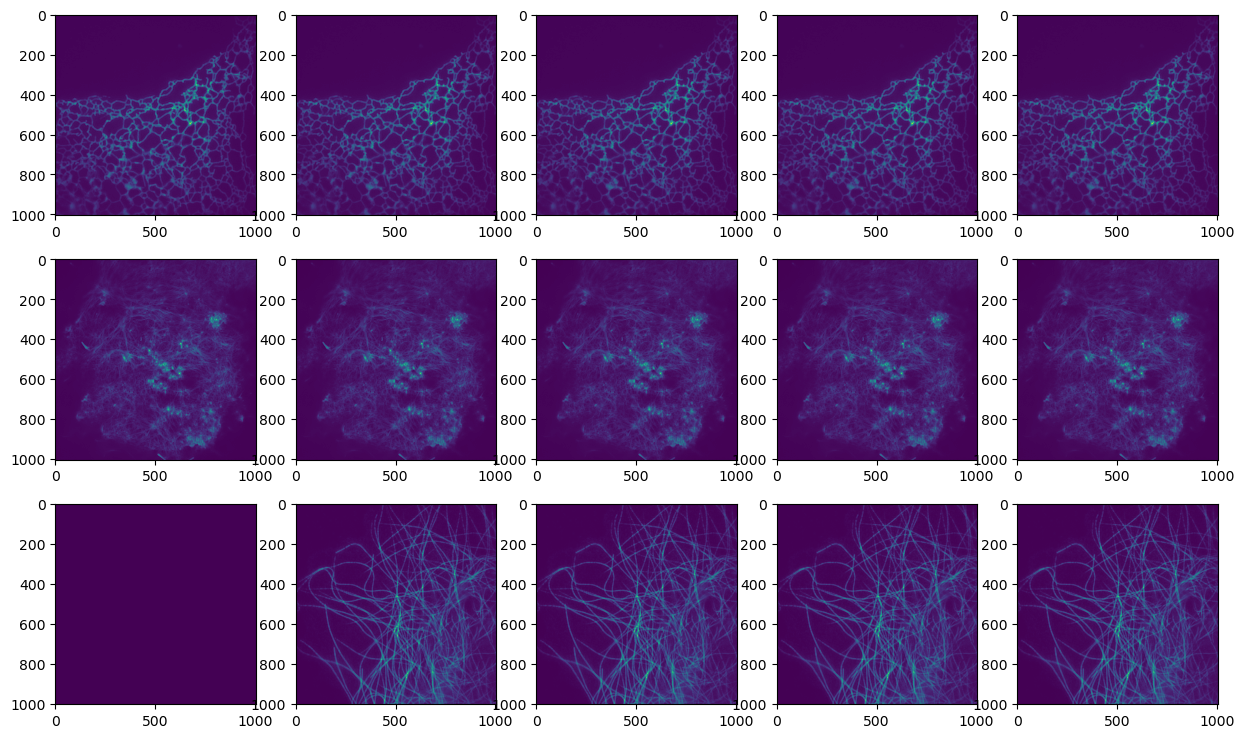

In [22]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(3, 5, figsize=(15, 9))
for i in range(len(fluorophores)):
    ax[i, 0].imshow(em[2, i, 0])
    ax[i, 1].imshow(em[8, i, 0])
    ax[i, 2].imshow(em[14, i, 0])
    ax[i, 3].imshow(em[20, i, 0])
    ax[i, 4].imshow(em[26, i, 0])

em1=em[14, i, 0]
em2=em[20, i, 0]
em3=em[26, i, 0]
print(em1.mean().item(), em2.mean().item(), em3.mean().item())
print(em1.std().item(), em2.std().item(), em3.std().item())

2.6320598020470056 15.350976931814749 93.36501020038965
3.2429127457965303 18.91365793204781 115.03332156617134


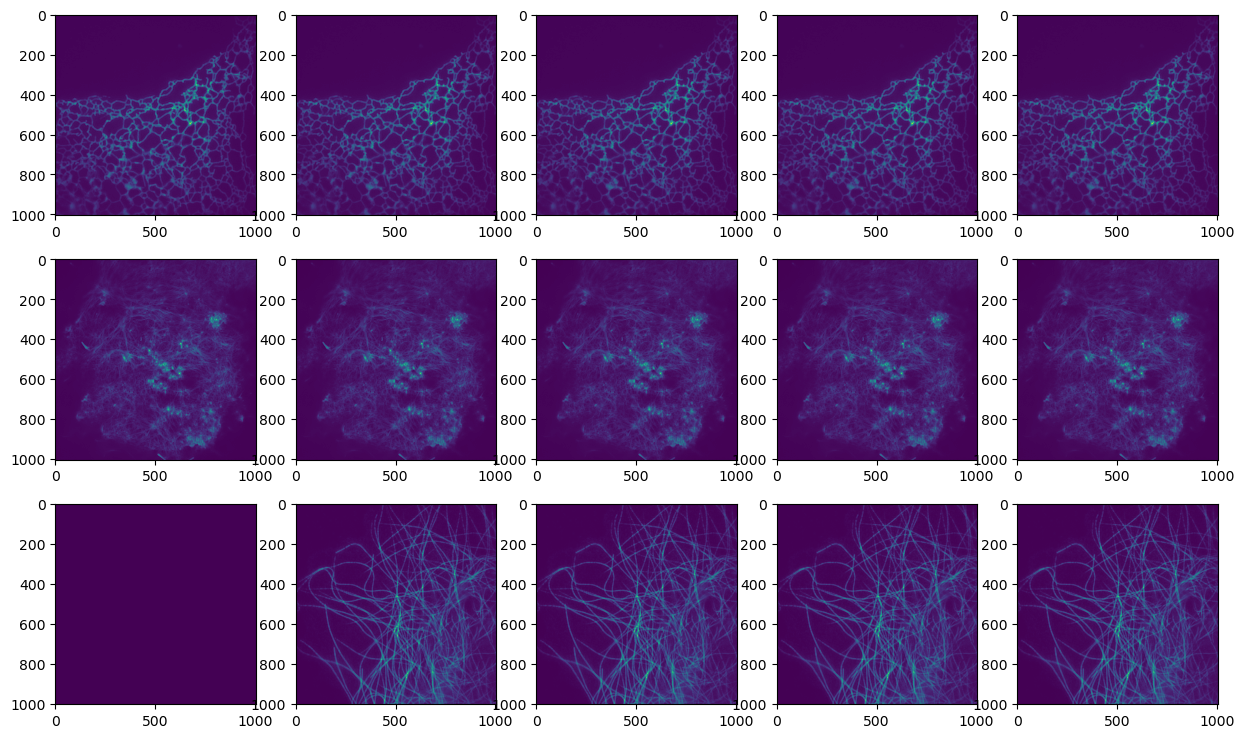

In [23]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(3, 5, figsize=(15, 9))
for i in range(len(fluorophores)):
    ax[i, 0].imshow(opt[2, i, 0])
    ax[i, 1].imshow(opt[8, i, 0])
    ax[i, 2].imshow(opt[14, i, 0])
    ax[i, 3].imshow(opt[20, i, 0])
    ax[i, 4].imshow(opt[26, i, 0])

opt1=opt[14, i, 0]
opt2=opt[20, i, 0]
opt3=opt[26, i, 0]
print(opt1.mean().item(), opt2.mean().item(), opt3.mean().item())
print(opt1.std().item(), opt2.std().item(), opt3.std().item())

100.04995158807003 100.28372565514833 101.70246504023746
1.397763795750112 1.4470731812728865 2.5034878518281687


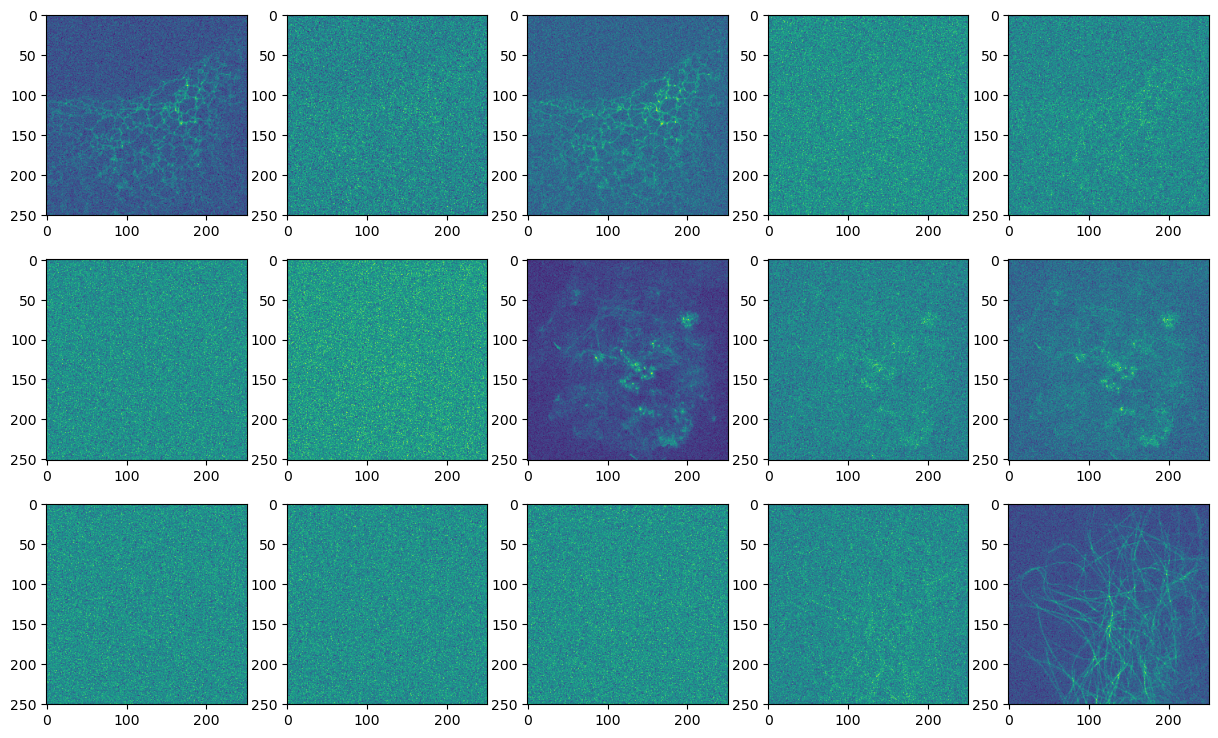

In [24]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(3, 5, figsize=(15, 9))
for i in range(len(fluorophores)):
    ax[i, 0].imshow(dig_per_fluor[2, i, 0])
    ax[i, 1].imshow(dig_per_fluor[8, i, 0])
    ax[i, 2].imshow(dig_per_fluor[14, i, 0])
    ax[i, 3].imshow(dig_per_fluor[20, i, 0])
    ax[i, 4].imshow(dig_per_fluor[26, i, 0])

dig_per_fluor1=dig_per_fluor[14, i, 0]
dig_per_fluor2=dig_per_fluor[20, i, 0]
dig_per_fluor3=dig_per_fluor[26, i, 0]
print(dig_per_fluor1.mean().item(), dig_per_fluor2.mean().item(), dig_per_fluor3.mean().item())
print(dig_per_fluor1.std().item(),  dig_per_fluor2.std().item(),  dig_per_fluor3.std().item())

102.92790590625546 100.73567086236726 102.7348454786432
2.8847663016391762 1.5617180603816596 2.8782746961118755


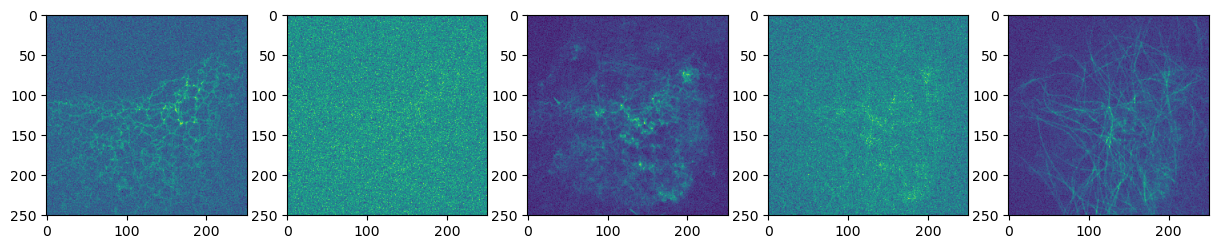

In [25]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].imshow(dig[2, 0])
ax[1].imshow(dig[8, 0])
ax[2].imshow(dig[14, 0])
ax[3].imshow(dig[20, 0])
ax[4].imshow(dig[26, 0])

dig1=dig[14, 0]
dig2=dig[20, 0]
dig3=dig[26, 0]
print(dig1.mean().item(), dig2.mean().item(), dig3.mean().item())
print(dig1.std().item(), dig2.std().item(), dig3.std().item())

mTurquoise: 50%: 583.77, 75%: 1362.14, 95%: 3891.81, 99%: 5594.48
EGFP: 50%: 1362.36, 75%: 2298.98, 95%: 4938.55, 99%: 8514.74
EYFP: 50%: 447.90, 75%: 1791.59, 95%: 4095.06, 99%: 6718.46
Mixed image: 50%: 3442.17, 75%: 5483.80, 95%: 9741.85, 99%: 14098.44


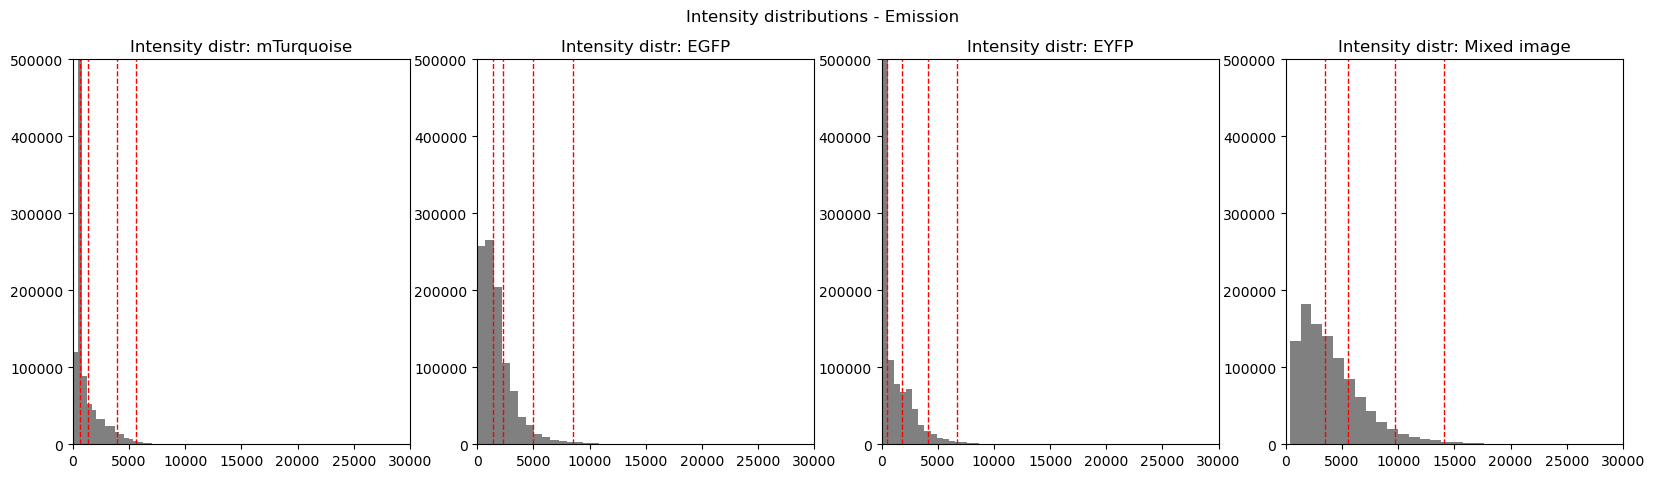

In [10]:
from microsim.util import intensity_histograms

intensity_histograms(em, "Emission", 5e5, 3e4)

In [12]:
tiff.imsave("../digital_try.tif", dig.values.astype(np.uint16))

/tmp/ipykernel_308/1038119980.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave("../digital_try.tif", dig.values.astype(np.uint16))


In [ ]:
res, sim_metadata = simulate_dataset(
    labels=labels,
    fluorophores=fluorophores,
    num_simulations=100,
    root_dir=ROOT_DIR
)